In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds


import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt

import re
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install transformers torch --quiet

# Data

In [4]:
# Get Dataset
gw_sentences_df = pd.read_csv('/content/drive/MyDrive/w266/Final Project/GWStance GWSD.csv', sep='\t')
gw_sentences_df = gw_sentences_df[5:] # remove first five rows; they're screen sentences we use to make sure that annotators correctly understand the task.
gw_sentences_df.head()

,Unnamed: 0,round,batch,sent_id,sentence,worker_0,worker_1,worker_2,worker_3,worker_4,worker_5,worker_6,worker_7,disagree,agree,neutral,guid,in_held_out_test
5,5,1,0,t0,Warmer-than-normal sea surface temperatures ar...,neutral,neutral,neutral,agrees,agrees,agrees,agrees,agrees,0.003105,0.711260,0.285634,1_0_t0,False
6,6,1,0,t1,We will continue to rely in part on fossil fue...,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,0.000830,0.001163,0.998006,1_0_t1,False
7,7,1,0,t10,The actual rise in sea levels measured only 1....,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,0.000802,0.001174,0.998023,1_0_t10,False
8,8,1,0,t11,Claims of global warming have been greatly exa...,disagrees,disagrees,disagrees,disagrees,disagrees,disagrees,disagrees,disagrees,0.997695,0.001171,0.001134,1_0_t11,False
9,9,1,0,t12,The Intergovernmental Panel on Climate Change ...,neutral,disagrees,neutral,neutral,neutral,neutral,neutral,neutral,0.031351,0.002962,0.965687,1_0_t12,False


In [5]:
# Drop irrelevant columns, split into test and train
gwsd = gw_sentences_df[['sentence', 'agree', 'disagree', 'neutral', 'in_held_out_test']]

# Make fxn to categorize sentiment
def categorize_sentiment(agree, disagree, neutral):
    if disagree > agree and disagree > neutral:
        return 1
    elif neutral > agree and neutral > disagree:
        return 0
    else:
        return 2

# Apply fxn to make 0, 1, 2 for
gwsd['sentiment'] = gwsd.apply(lambda row: categorize_sentiment(row['agree'], row['disagree'], row['neutral']), axis=1)
gwsd.head()

<ipython-input-5-b17ddf060ae2>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gwsd['sentiment'] = gwsd.apply(lambda row: categorize_sentiment(row['agree'], row['disagree'], row['neutral']), axis=1)


,sentence,agree,disagree,neutral,in_held_out_test,sentiment
5,Warmer-than-normal sea surface temperatures ar...,0.711260,0.003105,0.285634,False,2
6,We will continue to rely in part on fossil fue...,0.001163,0.000830,0.998006,False,0
7,The actual rise in sea levels measured only 1....,0.001174,0.000802,0.998023,False,0
8,Claims of global warming have been greatly exa...,0.001171,0.997695,0.001134,False,1
9,The Intergovernmental Panel on Climate Change ...,0.002962,0.031351,0.965687,False,0


In [6]:
# Split into train and test sets

train_sentences = gwsd['sentence'][gwsd['in_held_out_test'] == 0]
test_sentences = gwsd['sentence'][gwsd['in_held_out_test'] == 1]

print("Train and test sentence shapes:", train_sentences.shape, test_sentences.shape)

train_sentiment = gwsd['sentiment'][gwsd['in_held_out_test'] == 0]
train_sentiment = tf.convert_to_tensor(train_sentiment, dtype=tf.int32)
test_sentiment = gwsd['sentiment'][gwsd['in_held_out_test'] == 1]
test_sentiment = tf.convert_to_tensor(test_sentiment, dtype=tf.int32)

print("Train and test sentiment shapes:",train_sentiment.shape, test_sentiment.shape)

# Turn into TF Tensors
train_sentences = tf.convert_to_tensor(train_sentences.values, dtype=tf.string)
test_sentences = tf.convert_to_tensor(test_sentences.values, dtype=tf.string)


Train and test sentence shapes: (2095,) (200,)
Train and test sentiment shapes: (2095,) (200,)


In [7]:
# Get MAX_SEQUENCE_LENGTH
MAX_SEQUENCE_LENGTH = gwsd['sentence'].apply(lambda x: len(x.encode('utf-8'))).max()

print("Max UTF-8 sequence length:", MAX_SEQUENCE_LENGTH)

# Encode and Tokenize train and test sets
train_sentences = [x.decode('utf-8') for x in train_sentences.numpy()]
test_sentences = [x.decode('utf-8') for x in test_sentences.numpy()]

# x_train = bert_tokenizer(train_sentences,
#                          max_length=MAX_SEQUENCE_LENGTH,
#                          truncation=True,
#                          padding='max_length',
#                          return_tensors='tf')
# x_test = bert_tokenizer(test_sentences,
#                         max_length=MAX_SEQUENCE_LENGTH,
#                         truncation=True,
#                         padding='max_length',
#                         return_tensors='tf')

Max UTF-8 sequence length: 347


# Climate BERT, finetune

We're going to finetune the hyperparameters to get the most optimal ClimateBERT model.

In [8]:
# Load Climate BERT tokenizer and model
from transformers import AutoTokenizer, TFAutoModel

climatebert_tokenizer = AutoTokenizer.from_pretrained("climatebert/distilroberta-base-climate-f")
climatebert_model = TFAutoModel.from_pretrained('climatebert/distilroberta-base-climate-f')
checkpoint_2 = 'climatebert/distilroberta-base-climate-f'


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.15M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/4.98k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/752 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [9]:
# Tokenize
x_train = climatebert_tokenizer(train_sentences,
                         max_length=MAX_SEQUENCE_LENGTH,
                         truncation=True,
                         padding='max_length',
                         return_tensors='tf')
x_test = climatebert_tokenizer(test_sentences,
                        max_length=MAX_SEQUENCE_LENGTH,
                        truncation=True,
                        padding='max_length',
                        return_tensors='tf')

In [21]:
# define the climate bert model

def create_climatebert_multiclass_model(checkpoint = checkpoint_2,
                                        num_classes = 3,
                                        hidden_size = 201,
                                        dropout=0.3,
                                        learning_rate=0.00005,
                                        pooler=True):
    """
    Build a simple classification model with BERT. Use the Pooler Output for classification purposes.
    """
    # get a Climate BERT model with input checkpoint and make fully traininable
    climatebert_model.trainable = True

    # make input layers
    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='attention_mask_layer')

    # BERT
    bert_inputs = {'input_ids': input_ids,
                   'attention_mask': attention_mask}

    bert_out = climatebert_model(bert_inputs)

    # get pooler and cls token
    if pooler:
      token = bert_out[1] #pooler token
    else:
      token = bert_out[0][:, 0, :] #CLS token

    # HIDDEN LAYER
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(token)

    # DROPOUT
    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    # CLASSIFICATION
    classification = tf.keras.layers.Dense(num_classes, activation='softmax',name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                                 metrics='accuracy')


    ### END YOUR CODE
    return classification_model

In [14]:
# make Pooler Model
pooler_climatebert_model = create_climatebert_multiclass_model(pooler=True)
pooler_climatebert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 347)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 347)]                0         []                            
 r)                                                                                               
                                                                                                  
 tf_roberta_model (TFRobert  TFBaseModelOutputWithPooli   8229888   ['attention_mask_layer[0][0]',
 aModel)                     ngAndCrossAttentions(last_   0          'input_ids_layer[0][0]'] 

In [22]:
# Make CLS model
cls_climatebert_model = create_climatebert_multiclass_model(pooler=False)
cls_climatebert_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 347)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 347)]                0         []                            
 r)                                                                                               
                                                                                                  
 tf_roberta_model (TFRobert  TFBaseModelOutputWithPooli   8229888   ['attention_mask_layer[0][0]',
 aModel)                     ngAndCrossAttentions(last_   0          'input_ids_layer[0][0]'

In [16]:
# Pooler Training
pooler_climatebert_model_history = pooler_climatebert_model.fit([x_train.input_ids, x_train.attention_mask],
                                                  train_sentiment,
                                                  validation_split=0.1, # split 10% of data for validation
                                                  batch_size=8,
                                                  epochs=1)

236/236 [==============================] - 109s 354ms/step - loss: 0.8433 - accuracy: 0.6080 - val_loss: 0.7633 - val_accuracy: 0.7000


In [23]:
# CLS Training
cls_climatebert_model_history = cls_climatebert_model.fit([x_train.input_ids, x_train.attention_mask],
                                                  train_sentiment,
                                                  validation_split=0.1, # split 10% of data for validation
                                                  batch_size=8,
                                                  epochs=1)

236/236 [==============================] - 101s 354ms/step - loss: 0.3477 - accuracy: 0.8790 - val_loss: 0.7540 - val_accuracy: 0.7286


Error is normal for the CLS token (was also in Text_Classification_BERTipnyb assignment).

Looks like CLS is slightly better in validation accuracy, however it may be overtraining due to almost 20% difference in accuracy between train and validation.

In [25]:
# Try different dropout parameters with POOLER to see what's better.

for dropout_value in [0.2, 0.3, 0.4, 0.5]:
    pooler_climatebert_model = create_climatebert_multiclass_model(pooler=True, dropout=dropout_value)
    pooler_model_history = pooler_climatebert_model.fit([x_train.input_ids, x_train.attention_mask],
                                                  train_sentiment,
                                                  validation_split=0.1, # split 10% of data for validation
                                                  batch_size=8,
                                                  epochs=1)


236/236 [==============================] - 98s 341ms/step - loss: 0.1030 - accuracy: 0.9740 - val_loss: 1.4756 - val_accuracy: 0.6905


In [26]:
# Try different dropout parameters with CLS to see what's better.

for dropout_value in [0.2, 0.3, 0.4, 0.5]:
    cls_climatebert_model = create_climatebert_multiclass_model(pooler=False, dropout=dropout_value)
    cls_model_history = cls_climatebert_model.fit([x_train.input_ids, x_train.attention_mask],
                                                  train_sentiment,
                                                  validation_split=0.1, # split 10% of data for validation
                                                  batch_size=8,
                                                  epochs=1)


236/236 [==============================] - 97s 340ms/step - loss: 0.0654 - accuracy: 0.9804 - val_loss: 1.8827 - val_accuracy: 0.6810


236/236 [==============================] - 101s 347ms/step - loss: 0.0507 - accuracy: 0.9825 - val_loss: 2.0670 - val_accuracy: 0.7048


236/236 [==============================] - 100s 349ms/step - loss: 0.0725 - accuracy: 0.9756 - val_loss: 1.9809 - val_accuracy: 0.6667


236/236 [==============================] - 100s 353ms/step - loss: 0.0759 - accuracy: 0.9761 - val_loss: 1.8943 - val_accuracy: 0.6952


Seems like dropout doesn't affect these things too much. Let's look at learning rate

In [30]:
learning_rate_range = [0.00001, 0.00002, 0.00003, 0.00004, 0.00005]
results = []

# CLS
for learning_rate_value in learning_rate_range:
    lr_cls_climatebert_model = create_climatebert_multiclass_model(pooler=False, learning_rate=learning_rate_value)
    lr_cls_model_history = lr_cls_climatebert_model.fit([x_train.input_ids, x_train.attention_mask],
                                                  train_sentiment,
                                                  validation_split=0.1, # split 10% of data for validation
                                                  batch_size=8,
                                                  epochs=1)

    # Extract metrics
    train_acc = lr_cls_model_history.history['accuracy'][-1]  # Final training accuracy
    val_acc = lr_cls_model_history.history['val_accuracy'][-1]  # Final validation accuracy

    # Save to results
    results.append({
        'Model': 'CLS',
        'Learning Rate': learning_rate_value,
        'Train Accuracy': train_acc,
        'Validation Accuracy': val_acc
    })

# Pooler
for learning_rate_value in learning_rate_range:
    lr_pooler_climatebert_model = create_climatebert_multiclass_model(pooler=True, learning_rate=learning_rate_value)
    lr_pooler_model_history = lr_pooler_climatebert_model.fit([x_train.input_ids, x_train.attention_mask],
                                                  train_sentiment,
                                                  validation_split=0.1, # split 10% of data for validation
                                                  batch_size=8,
                                                  epochs=1)
    # Extract metrics
    train_acc = lr_pooler_model_history.history['accuracy'][-1]  # Final training accuracy
    val_acc = lr_pooler_model_history.history['val_accuracy'][-1]  # Final validation accuracy

    # Save to results
    results.append({
        'Model': 'Pooler',
        'Learning Rate': learning_rate_value,
        'Train Accuracy': train_acc,
        'Validation Accuracy': val_acc
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

236/236 [==============================] - 99s 350ms/step - loss: 0.1863 - accuracy: 0.9342 - val_loss: 1.4734 - val_accuracy: 0.6952


236/236 [==============================] - 98s 345ms/step - loss: 0.0734 - accuracy: 0.9729 - val_loss: 1.6821 - val_accuracy: 0.6952


236/236 [==============================] - 97s 340ms/step - loss: 0.0507 - accuracy: 0.9867 - val_loss: 1.9988 - val_accuracy: 0.6952


236/236 [==============================] - 98s 344ms/step - loss: 0.0444 - accuracy: 0.9867 - val_loss: 2.3364 - val_accuracy: 0.6762


236/236 [==============================] - 99s 351ms/step - loss: 0.0622 - accuracy: 0.9841 - val_loss: 1.9190 - val_accuracy: 0.6952


In [31]:
results_df

,Model,Learning Rate,Train Accuracy,Validation Accuracy
0,CLS,0.00001,0.934218,0.695238
1,CLS,0.00002,0.972944,0.695238
2,CLS,0.00003,0.986737,0.695238
3,CLS,0.00004,0.986737,0.676190
4,CLS,0.00005,0.980902,0.652381
5,Pooler,0.00001,0.975597,0.700000
6,Pooler,0.00002,0.977188,0.680952
7,Pooler,0.00003,0.992042,0.700000
8,Pooler,0.00004,0.988859,0.695238
9,Pooler,0.00005,0.984085,0.695238


In [36]:
results_df

,Model,Learning Rate,Train Accuracy,Validation Accuracy
0,CLS,0.00001,0.934218,0.695238
1,CLS,0.00002,0.972944,0.695238
2,CLS,0.00003,0.986737,0.695238
3,CLS,0.00004,0.986737,0.676190
4,CLS,0.00005,0.980902,0.652381
5,Pooler,0.00001,0.975597,0.700000
6,Pooler,0.00002,0.977188,0.680952
7,Pooler,0.00003,0.992042,0.700000
8,Pooler,0.00004,0.988859,0.695238
9,Pooler,0.00005,0.984085,0.695238


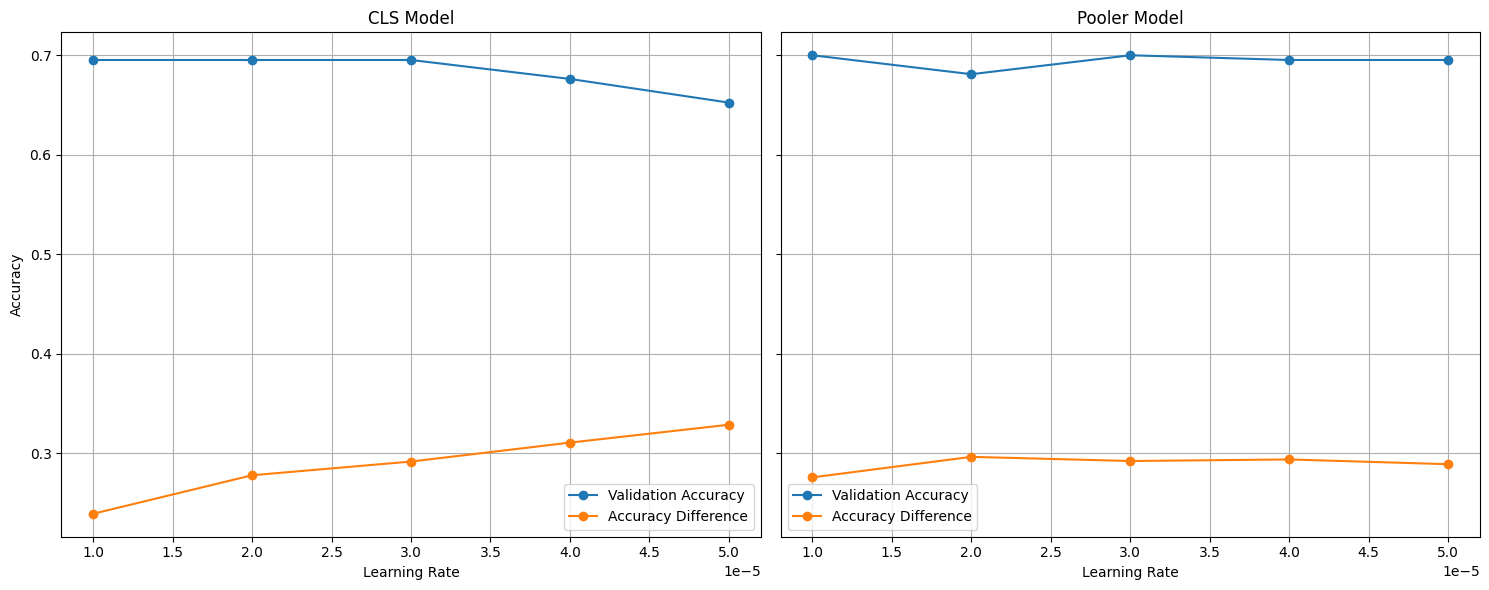

In [42]:
import matplotlib.pyplot as plt

# Calculate the accuracy difference
results_df["Accuracy Difference"] = results_df["Train Accuracy"] - results_df["Validation Accuracy"]

# Filter data by model
cls_data = results_df[results_df["Model"] == "CLS"]
pooler_data = results_df[results_df["Model"] == "Pooler"]

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Plot for CLS model
axes[0].plot(cls_data["Learning Rate"], cls_data["Validation Accuracy"], label="Validation Accuracy", marker="o")
axes[0].plot(cls_data["Learning Rate"], cls_data["Accuracy Difference"], label="Accuracy Difference", marker="o")
axes[0].set_title("CLS Model")
axes[0].set_xlabel("Learning Rate")
axes[0].set_ylabel("Accuracy")
axes[0].legend()
axes[0].grid(True)

# Plot for Pooler model
axes[1].plot(pooler_data["Learning Rate"], pooler_data["Validation Accuracy"], label="Validation Accuracy", marker="o")
axes[1].plot(pooler_data["Learning Rate"], pooler_data["Accuracy Difference"], label="Accuracy Difference", marker="o")
axes[1].set_title("Pooler Model")
axes[1].set_xlabel("Learning Rate")
axes[1].legend()
axes[1].grid(True)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()



From this, we can see that for the CLS model, a higher learning rate reduces the validation accuracy and also increases the difference between training and validation accuracy. We can see that the pooler model isn't as affected by this.

NOTES: I will probably need to look at what I did wrong in assignment 2 and instantiate a new BERT model for each instance and re-run